# Set up and import

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.decomposition import PCA
%run ../lib/load.py

In [3]:
path = '/Users/zhaoziqin/Desktop/train_set/'
data = load.load_data(path+'label.csv')
points_path = '/Users/zhaoziqin/Desktop/train_set/points/'
X = load.load_points(points_path,data)
y= data['emotion_idx'].to_numpy()

--- 14.434093713760376 seconds ---


# Train-test split

In [4]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=123)

In [5]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2000, 6006)
(500, 6006)
(2000,)
(500,)


# Baseline model (GBM)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier 
start_time = time.time()
baseline = GradientBoostingClassifier(n_estimators=22,max_depth=2)
gbm_model = GradientBoostingClassifier(n_estimators=22,max_depth=2).fit(train_x,train_y) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 374.0963981151581 seconds ---


In [7]:
from sklearn.metrics import classification_report
baseline_pred = gbm_model.predict(test_x)
baseline_accuracy = gbm_model.score(test_x,test_y)
print("Accuracy on the baseline model: %.4f" % (baseline_accuracy))
baseline_pred_train = gbm_model.predict(train_x)
print(classification_report(train_y, baseline_pred_train))
print(classification_report(test_y, baseline_pred))

Accuracy on the baseline model: 0.3780
              precision    recall  f1-score   support

           1       0.83      0.87      0.85        94
           2       0.90      0.93      0.91        95
           3       0.81      0.92      0.86       110
           4       0.87      0.86      0.86        97
           5       0.93      0.90      0.92        91
           6       0.86      0.83      0.84        78
           7       0.88      0.88      0.88        94
           8       0.92      0.93      0.92       104
           9       0.89      0.89      0.89        84
          10       0.82      0.89      0.85        87
          11       0.89      0.81      0.85        99
          12       0.98      0.80      0.88        80
          13       0.87      0.81      0.84        83
          14       0.82      0.93      0.87        99
          15       0.93      0.78      0.85        73
          16       0.87      0.90      0.89        91
          17       0.79      0.87      0.8

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y,baseline_pred)

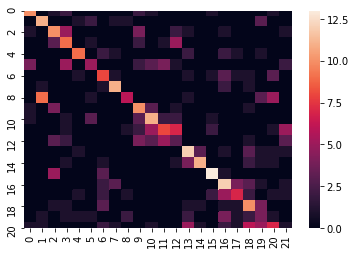

In [9]:
import seaborn as sns
sns.heatmap(cm)

In [10]:
# save baseline model
# from sklearn.externals import joblib
# joblib.dump(gbm_model,'../output/baseline.m')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['../output/baseline.m']

# XGBoost

In [11]:
# conda install -c conda-forge xgboost
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Principal Component Analysis (PCA) for XGBoost 

In [12]:
pca= PCA(random_state = 123)
pca.fit(train_x)
k=0
total= sum(pca.explained_variance_)
current_sum=0
while current_sum/total < 0.95: 
    current_sum += pca.explained_variance_[k]
    k+=1
print(k)
pca1=PCA(n_components=k,whiten=True)
train_transform_data= pca1.fit_transform(train_x)
print(train_transform_data.shape)
test_transform_data=pca1.transform(test_x)
print(test_transform_data.shape)

25
(2000, 25)
(500, 25)


#### Cross Validation XGBoost

In [14]:
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(objective='multi:softprob',seed=36)
parameters = {
   'max_depth': range (1, 5, 1),
   'n_estimators': range(1, 200, 20),
   'learning_rate': [0.1, 0.01, 0.05]
}

gscv1 = GridSearchCV(estimator = estimator , 
                        param_grid = parameters, 
                        scoring ='accuracy',
                        cv = 5,
                        n_jobs = -1)
gscv1.fit(train_transform_data, train_y)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=36, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(1, 5),
                         'n_estimators': range(1, 200, 20)},

In [16]:
# accuracy score
print('Best score for data:', gscv1.best_score_) 

# Find the best parameters for the model by using grid search
print('Best Max Depth:',gscv1.best_estimator_.max_depth) 
print('Best N.estimators:',gscv1.best_estimator_.n_estimators)
print('Best Learning Rate:',gscv1.best_estimator_.learning_rate)

Best score for data: 0.3335
Best Max Depth: 2
Best N.estimators: 181
Best Learning Rate: 0.1


In [19]:
start_time = time.time()
xgb_new = XGBClassifier(
    n_estimators=181,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    max_depth=2,
    colsample_bytree = 0.8,
    learning_rate=0.1,
    reg_alpha = 0.005)
xgb_model = xgb_new.fit(train_x,train_y)

xgb_test_pred = xgb_model.predict(test_x)
xgb_accuracy = xgb_model.score(test_x,test_y)
print("Accuracy on the baseline model: %.4f" % (xgb_accuracy))
xgb_train_pred = xgb_model.predict(train_x)
print(classification_report(train_y, xgb_train_pred))
print(classification_report(test_y, xgb_test_pred))
print("--- %s seconds ---" % (time.time() - start_time))

Accuracy on the baseline model: 0.4960
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        94
           2       1.00      1.00      1.00        95
           3       1.00      1.00      1.00       110
           4       1.00      1.00      1.00        97
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00        94
           8       1.00      1.00      1.00       104
           9       1.00      1.00      1.00        84
          10       1.00      1.00      1.00        87
          11       1.00      1.00      1.00        99
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        83
          14       1.00      1.00      1.00        99
          15       1.00      1.00      1.00        73
          16       1.00      1.00      1.00        91
          17       1.00      1.00      1.0

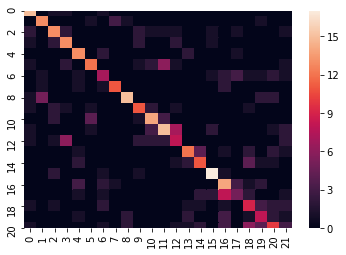

In [20]:
cm_xgb = confusion_matrix(test_y,xgb_test_pred)
sns.heatmap(cm_xgb)

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()
start_time = time.time() 
param_grid = {'C': [0.001, 0.01, 1, 5, 10, 25] }
gscv2 = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv = None,
             estimator = LogisticRegression(C=1.0, intercept_scaling=1,
                                          dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid= {'C':[0.001, 0.01, 1, 5, 10, 25]},n_jobs=-1)

gscv2.fit(train_x, train_y)

print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


--- 2690.433163166046 seconds ---


In [25]:
gscv2.best_estimator_
# gscv2.best_params_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
start_time = time.time() 
lr = LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
lr_model = lr.fit(train_x,train_y)
print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


--- 179.69380617141724 seconds ---


In [31]:
lr_test_pred = lr_model.predict(test_x)
lr_accuracy = lr_model.score(test_x,test_y)
print("Accuracy on the baseline model: %.4f" % (lr_accuracy))
lr_train_pred = lr_model.predict(train_x)
print(classification_report(train_y, lr_train_pred))
print(classification_report(test_y, lr_test_pred))

Accuracy on the baseline model: 0.4780
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        94
           2       1.00      1.00      1.00        95
           3       1.00      1.00      1.00       110
           4       1.00      0.99      0.99        97
           5       0.99      1.00      0.99        91
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00        94
           8       1.00      1.00      1.00       104
           9       1.00      1.00      1.00        84
          10       0.99      1.00      0.99        87
          11       0.99      1.00      0.99        99
          12       1.00      0.99      0.99        80
          13       1.00      0.99      0.99        83
          14       0.98      1.00      0.99        99
          15       0.99      0.96      0.97        73
          16       1.00      1.00      1.00        91
          17       1.00      1.00      1.0